# <font color="blue">Project: DoppelGanger </font>
We have seen how face Recognition algorithms work. In short, they convert a face into a high dimensional vector and then learn a feature space in that high dimension. Once the algorithm learns a robust feature space, you can add more people to the same space and they will form a different cluster.

In this project, I will use the Face Embeddings to **find a doppelganger or look-alike to a given person.** Specifically, there will be images of two persons and a celebrity dataset. The task will be to find their celebrity look-alike. The first person is **Sofia Solares** who looks like the American Singer **Selena Gomez** and the second one is **Shashikant Pedwal** who looks like Indian Film Actor **Amitabh Bachchan**.

What will happen is simply get a dataset which has enough celebrity faces and use face embeddings to match the test image with the celebrity face embeddings. 

## <font color="blue">The Dataset</font>
There are many datasets which contain images of celebrities. Some of them are:
* [CelebA Dataset](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html)
* [VGGFace](https://www.robots.ox.ac.uk/~vgg/data/vgg_face/)
* [VGGFace2](http://www.robots.ox.ac.uk/~vgg/data/vgg_face2/)
* [MS-Celeb-1M](https://www.microsoft.com/en-us/research/project/ms-celeb-1m-challenge-recognizing-one-million-celebrities-real-world/)
* [Celebrity-Together Dataset](https://www.robots.ox.ac.uk/~vgg/data/celebrity_together/)

### <font color="green">celeb_mini Dataset</font>
Since most of the datasets are huge in size, so a small dataset has curated for this experiment.

A subset of the Query set of the Celebrity Together Dataset will be used in this project. The query dataset has around 1100 celebs and is ~400MB in size. 

The subset created is using 5 images per celebrity and it has been saved in the **`../resource/asnlib/publicdata/celeb_mini`** folder. It is ~70MB in size. It have also provided a **`celeb_mapping.npy`** file which has the mapping of the code name to the actual name of the celebrity.

The **`celeb_mini`** folder has the following structure:

```
celeb_mini
└───n00000001
│   └──n00000001_00000263.JPEG
│   └──n00000001_00000405.JPEG
│      ...
└───n00000003
│   └──n00000003_00000386.JPEG
│   └──n00000003_00000488.JPEG
│       ...
│
```
    
**`celeb_mapping.npy`** contains a dictionary which contains the mapping between the folder names and the celebrity's actual name as show below:
```
{'n00000001': 'A.J. Buckley',
 'n00000002': 'A.R. Rahman',
 'n00000003': 'Aamir Khan',
 'n00000004': 'Aaron Staton',
 'n00000005': 'Aaron Tveit',
 'n00000006': 'Aaron Yoo',
 'n00000007': 'Abbie Cornish',
 .
 .
 .
}
```

In [19]:
import os,random,glob
import dlib
import cv2
import numpy as np
import matplotlib.pyplot as plt
import time
%matplotlib inline

In [20]:
import matplotlib
matplotlib.rcParams['figure.figsize'] = (3.0,3.0)
matplotlib.rcParams['image.cmap'] = 'gray'
matplotlib.rcParams['image.interpolation'] = 'bilinear'

## <font color="blue">Load the model for face landmarks and face recognition</font>

Initialize Dlib’s Face Detector, Facial Landmark Detector and Face Recognition neural network objects

In [21]:
# Download dlib models

# Landmark model
#!wget https://github.com/davisking/dlib-models/raw/master/shape_predictor_68_face_landmarks.dat.bz2 -O shape_predictor_68_face_landmarks.dat.bz2
#!bzip2 -d shape_predictor_68_face_landmarks.dat.bz2

# Face recognition model
#!wget https://github.com/davisking/dlib-models/raw/master/dlib_face_recognition_resnet_model_v1.dat.bz2 -O dlib_face_recognition_resnet_model_v1.dat.bz2
#!bzip2 -d dlib_face_recognition_resnet_model_v1.dat.bz2

# Initialize face detector, facial landmarks detector and face recognizer
faceDetector = dlib.get_frontal_face_detector()
shapePredictor = dlib.shape_predictor('shape_predictor_68_face_landmarks.dat')
faceRecognizer = dlib.face_recognition_model_v1('dlib_face_recognition_resnet_model_v1.dat')

## <font color="blue">Explore Data </font>
Sample code of how to load the images and use the label mapping for your reference. This should help to get started with handling images and finding the embeddings.

In [22]:
#!wget https://www.dropbox.com/s/lulw2jwsblz687g/celeb_mini.zip?dl=1 -O celeb_mini.zip
#!unzip celeb_mini.zip

#!wget https://www.dropbox.com/s/m7kjjoa1z1hsxw6/celeb_mapping.npy?dl=1 -O celeb_mapping.npy

#!wget https://www.dropbox.com/s/3yi89blp4lhiw6y/test-images.zip?dl=1 -O test-images.zip
#!unzip test-images.zip

In [23]:
# Root folder of the dataset
faceDatasetFolder = 'celeb_mini'

# Label -> Name Mapping file
labelMap = np.load("celeb_mapping.npy", allow_pickle=True).item()

# Each subfolder has images of a particular celeb
subfolders = os.listdir(faceDatasetFolder)

# Let us choose a random folder and display all images
random_folder = random.choice(subfolders)

# Also find out the name of the celeb from the folder name and folder-> name mapping dictionary loaded earlier
celebname = labelMap[random_folder]

# Load all images in the subfolder
imagefiles = os.listdir(os.path.join(faceDatasetFolder, random_folder))

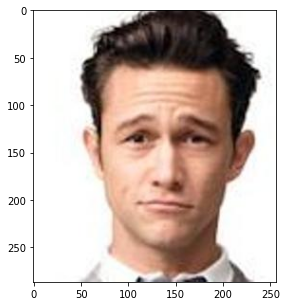

File path = celeb_mini\n00001216\n00001216_00000007.JPEG
Celeb Name: Joseph Gordon-Levitt


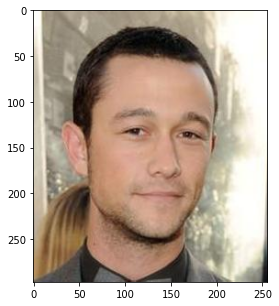

File path = celeb_mini\n00001216\n00001216_00000524.JPEG
Celeb Name: Joseph Gordon-Levitt


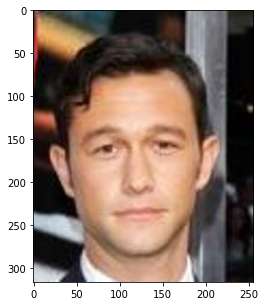

File path = celeb_mini\n00001216\n00001216_00000569.JPEG
Celeb Name: Joseph Gordon-Levitt


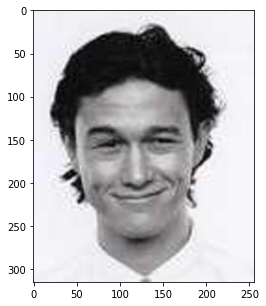

File path = celeb_mini\n00001216\n00001216_00000656.JPEG
Celeb Name: Joseph Gordon-Levitt


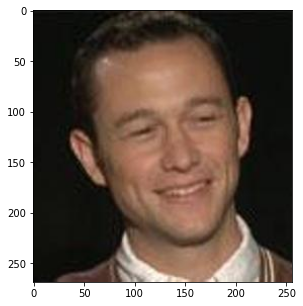

File path = celeb_mini\n00001216\n00001216_00000899.JPEG
Celeb Name: Joseph Gordon-Levitt


In [46]:
matplotlib.rcParams['figure.figsize'] = (5.0, 5.0)
# Read each image and display along with the filename and celeb name
for file in imagefiles:
#   Get full path of each image file
    fullPath = os.path.join(faceDatasetFolder,random_folder,file)
    im = cv2.imread(fullPath)
    plt.imshow(im[:,:,::-1])
    plt.show()
#   Also print the filename and celeb name
    print("File path = {}".format(fullPath))
    print("Celeb Name: {}".format(celebname))

## <font color="red">1. Enrollment of Celeb Images </font>
Process images one by and one. 

Convert image from RGB to BGR, because Dlib uses RGB as default format.

Detect faces in the image and compute a face descriptor for each image and save them in an array so that it can be used during testing.

In [ ]:
# read subfolders in folder "faces"
subfolders = []
for x in os.listdir(faceDatasetFolder):
    xpath = os.path.join(faceDatasetFolder, x)
    if os.path.isdir(xpath):
        subfolders.append(xpath)

# nameLabelMap is dict with keys as person's name and values as integer label assigned to this person
# labels contain integer labels for corresponding image in imagePaths
nameLabelMap = {}
labels = []
imagePaths = []

for i, subfolder in enumerate(subfolders):
    for x in os.listdir(subfolder):
        xpath = os.path.join(subfolder, x)
        if x.endswith('JPEG'):
            imagePaths.append(xpath)
            labels.append(i)
            nameLabelMap[xpath] = subfolder.split('/')[-1]


# Process images one by one: store face descriptors in an ndarray (faceDescriptors) and corresponding labels in dictionary (index)
index = {}
i = 0
faceDescriptors = None

for imagePath in imagePaths:
    #print("processing: {}".format(imagePath))
    # read image and convert it to RGB
    img = cv2.imread(imagePath)

    # detect faces in image
    faces = faceDetector(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    #print("{} Face(s) found".format(len(faces)))

    for k, face in enumerate(faces):
        # Find facial landmarks for each detected face
        shape = shapePredictor(cv2.cvtColor(img, cv2.COLOR_BGR2RGB), face)

        # convert landmarks from Dlib's format to list of (x, y) points
        landmarks = [(p.x, p.y) for p in shape.parts()]

        # Compute face descriptor using neural network defined in Dlib.
        # It is a 128D vector that describes the face in img identified by shape.
        faceDescriptor = faceRecognizer.compute_face_descriptor(img, shape)

        # Convert face descriptor from Dlib's format to list, then a NumPy array
        faceDescriptorList = [x for x in faceDescriptor]
        faceDescriptorNdarray = np.asarray(faceDescriptorList, dtype=np.float64)
        faceDescriptorNdarray = faceDescriptorNdarray[np.newaxis, :]
        
        # Stack face descriptors (1x128) for each face in images, as rows
        if faceDescriptors is None:
            faceDescriptors = faceDescriptorNdarray
        else:
            faceDescriptors = np.concatenate((faceDescriptors, faceDescriptorNdarray), axis=0)

        # save the label for this face in index. will identify person name corresponding to face descriptors stored.
        index[i] = nameLabelMap[imagePath]
        i += 1


In [ ]:
try:
    import cPickle  # Python 2
except ImportError:
    import _pickle as cPickle  # Python 3

# Write descriors and index to disk
np.save('descriptors.npy', faceDescriptors)

# index has image paths in same order as descriptors in faceDescriptors
with open('index.pkl', 'wb') as f:
    cPickle.dump(index, f)

## <font color="red">2. Testing</font>
Once enrolled the celebs, it should be able to use them to find the closest celeb to the given test image using minimum distance rule.

Find the embeddings of the test images and compare it with the enrolled celebs to find the look-alike. 

Finally, display the celeb along side the input image.

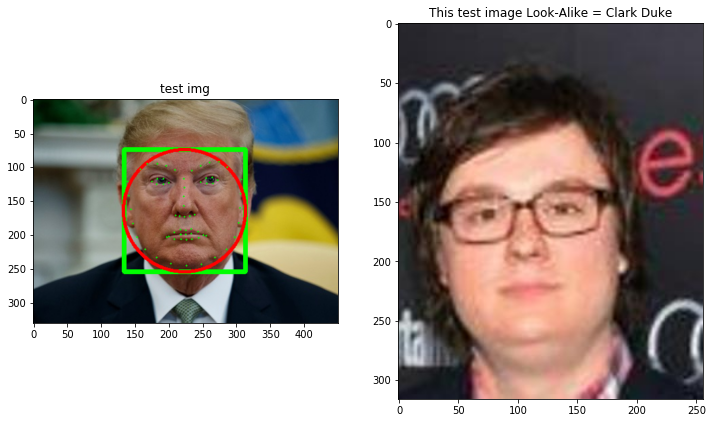

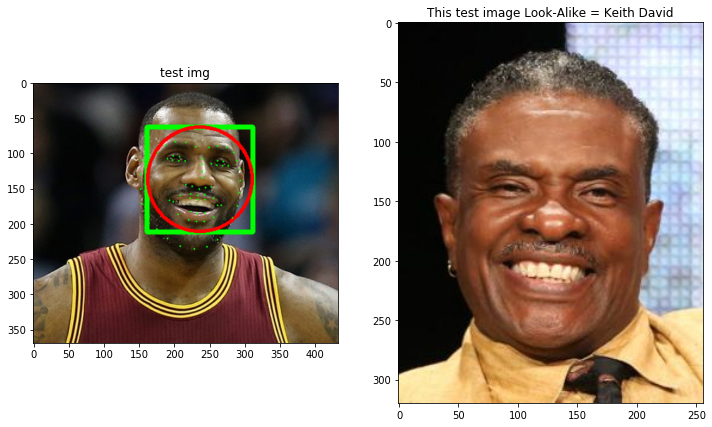

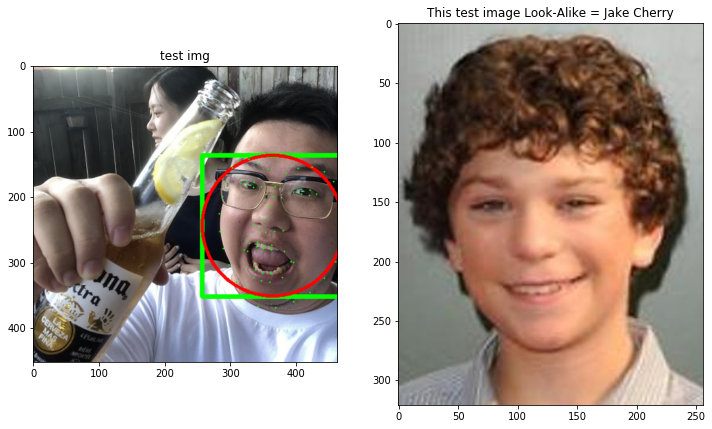

In [42]:
# load descriptors and index file generated during enrollment
index = np.load('index.pkl', allow_pickle=True)
faceDescriptorsEnrolled = np.load('descriptors.npy')

# read image
testImages = glob.glob('test-images/*.jpg')

matplotlib.rcParams['figure.figsize'] = (12.0,12.0)

for test in testImages:
    im = cv2.imread(test)
    faces = faceDetector(cv2.cvtColor(im, cv2.COLOR_BGR2RGB))



    for face in faces:
        # Find facial landmarks for each detected face
        shape = shapePredictor(cv2.cvtColor(im, cv2.COLOR_BGR2RGB), face)

        # find coordinates of face rectangle
        x1 = face.left()
        y1 = face.top()
        x2 = face.right()
        y2 = face.bottom()

        # Compute face descriptor using neural network defined in Dlib using facial landmark shape
        faceDescriptor = faceRecognizer.compute_face_descriptor(im, shape)

        # Convert face descriptor from Dlib's format to list, then a NumPy array
        faceDescriptorList = [m for m in faceDescriptor]
        faceDescriptorNdarray = np.asarray(faceDescriptorList, dtype=np.float64)
        faceDescriptorNdarray = faceDescriptorNdarray[np.newaxis, :]

        # Calculate Euclidean distances
        distances = np.linalg.norm(faceDescriptorsEnrolled - faceDescriptorNdarray, axis=1)
        
        # Calculate minimum distance and index
        argmin = np.argmin(distances)  # index
        minDistance = distances[argmin]  # minimum distance
       
        label = index[argmin]
        
        #celeb_name = printLabel
        celebname = labelMap[label.split('\\')[1]]

        # Draw a rectangle for detected face
        cv2.rectangle(im, (x1, y1), (x2, y2), (0, 255, 0),  thickness=5)

        # Draw circle for face recognition
        center = (int((x1 + x2)/2.0), int((y1 + y2)/2.0))
        radius = int((y2-y1)/2.0)
        color = (0, 0, 255)
        cv2.circle(im, center, radius, color, thickness=3, lineType=8, shift=0)
      
        # convert landmarks from Dlib's format to list of (x, y) points
        landmarks = [(p.x, p.y) for p in shape.parts()]
        for point in landmarks:
            cv2.circle(im, point, 1, (0, 255, 0), -1)
            

    plt.subplot(121)
    plt.imshow(cv2.cvtColor(im, cv2.COLOR_BGR2RGB))
    plt.title("test img")
    
    #TODO - display celeb image which looks like the test image instead of the black image. 
    plt.subplot(122) 
    files = os.listdir(label)
    FullPath = label+str("/")+files[0]
    im = cv2.imread(FullPath)
    plt.imshow(im[:,:,::-1])
    plt.title("This test image Look-Alike = {}".format(celebname))
    plt.show()